In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def sound_speed(P, rho):
    """Calculate sound speed."""
    P = abs(P)  # Ensure pressure is non-negative
    
    return np.sqrt(gamma * P / rho)











In [3]:
def compute_flux(U):
    """Compute the flux vector F for a single row of conserved variables."""
    rho, rho_v, E = U  # Extract variables
    
    # Compute velocity and pressure
    v = rho_v / rho  # Velocity
    P = (gamma - 1) * (E - 0.5 * rho * v ** 2)  # Pressure
    
    # Compute fluxes
    F = np.zeros(3)
    F[0] = rho_v  # Mass flux
    F[1] = rho_v * v + P  # Momentum flux
    F[2] = (E + P) * v  # Energy flux

    return F




In [36]:
def HLL_flux(UL, UR):
    """HLL Riemann solver to compute flux at the interface."""
    FL = compute_flux(UL)
    FR = compute_flux(UR)

    # Extract variables from left and right states
    rhoL, vL = UL[0], UL[1] / UL[0]
    rhoR, vR = UR[0], UR[1] / UR[0]

    # Compute pressures
    PL = (gamma - 1) * (UL[2] - 0.5 * UL[1]**2 / UL[0])
    PR = (gamma - 1) * (UR[2] - 0.5 * UR[1]**2 / UR[0])

    # Compute sound speeds
    cL = sound_speed(PL, rhoL)
    cR = sound_speed(PR, rhoR)

    # Compute wave speeds
    alpha_minus = min(vL - cL, vR - cR)  # Leftward moving wave speed
    alpha_plus = max(vL + cL, vR + cR)   # Rightward moving wave speed

#     # Compute the maximum wave speed for CFL condition
#     alpha_max = max(abs(alpha_minus), abs(alpha_plus))
    
    
#     print(FL)

    # Compute the HLL flux based on wave speeds
    if alpha_minus >= 0:
        flux = FL  # Use left flux if all waves move to the right
    elif alpha_plus <= 0:
        flux = FR  # Use right flux if all waves move to the left
    else:
        # Intermediate state: mix fluxes
        flux = (alpha_plus * FL + alpha_minus * FR -
                alpha_plus * alpha_minus * (UR - UL)) / (alpha_plus - alpha_minus)

    return flux # Return both flux and max wave speed




In [37]:
def update(U, dt):
    """Update conserved variables using fluxes."""
    U_new = np.copy(U)

    for i in range(1, len(U)-1):
        # Compute fluxes and wave speeds at the interfaces
        flux_left = HLL_flux(U[:,i - 1], U[:, i])


        U_new[:, i-1] -= dt/dx * (flux_left-compute_flux(U[:, i-1])) # 0.5 * global_max_alpha = dt/dx (0.5 is cfl)

        
    return U_new  # Return updated state and max alpha


In [50]:
# Parameters
gamma = 1.4  # Adiabatic index for ideal gas
Nx = 500 # Number of grid cells
x = np.linspace(0, 1, Nx)
dx = x[1] - x[0]  # Grid spacing
dt = 0.0001  # Time step

# Time step parameters
CFL = 0.5  # Courant number for stability
t_max = 0.01  # Maximum simulation time

In [51]:
# Initial conditions: (rho, u, p) on the left and right
rho_L, u_L, p_L = 1.0, 0.0, 1.0
rho_R, u_R, p_R = 0.125, 0.0, 0.1

# Initialize primitive variables
rho = np.zeros(Nx)
u = np.zeros(Nx)
p = np.zeros(Nx)

# Set initial conditions
rho[: Nx // 2] = rho_L
u[: Nx // 2] = u_L
p[: Nx // 2] = p_L

rho[Nx // 2 :] = rho_R
u[Nx // 2 :] = u_R
p[Nx // 2 :] = p_R

# Convert to conservative variables
E = p / (gamma - 1) + 0.5 * rho * u**2  # Energy density
U = np.array([rho, rho * u, E])  # [density, momentum, energy]



In [52]:
# Time integration loop
t = 0.0

while t < t_max:
    # Update the state and compute the global maximum wave speed
    U = update(U, dt)

    # Increment the time
    t += dt
    
    
# print(U)


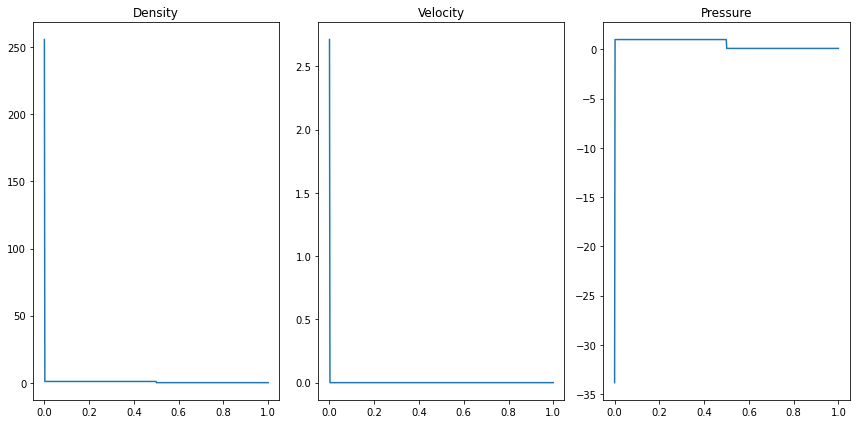

In [53]:
# Extract the final primitive variables
rho = U[0]
u = U[1] / rho
E = U[2]
p = (gamma - 1) * (E - 0.5 * rho * u**2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(x, rho)
plt.title("Density")

plt.subplot(132)
plt.plot(x, u)
plt.title("Velocity")

plt.subplot(133)
plt.plot(x, p)
plt.title("Pressure")

plt.tight_layout()
plt.show()
